In [1]:
# Read JIn-Si veg coverage and fit growth curve

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress
from scipy.integrate import odeint


from datetime import datetime as datetime
import time

In [2]:
%run -i funcs.py

In [3]:
ddir = 'C:/crs/proj/2023_NCB_recovery/'
# Extracted from Dorian sheet of Supplemental_Table.xlsx send by Jin-Si on Feb 6, 2024
fn = 'Supplemental_Table_Dorian_Veg_cover.csv'
df = pd.read_csv(ddir+fn, skiprows=[0,1])
df

,Dorian Outwash ID,Area m2,Dense Veg,Sparse Veg,Sand,Water,Unnamed: 6,Dense Veg.1,Sparse Veg.1,Sand.1,...,Unnamed: 11,Dense Veg.2,Sparse Veg.2,Sand.2,Water.2,Unnamed: 16,Dense Veg.3,Sparse Veg.3,Sand.3,Water.3
0,1,3045,1223,4281,6738,0,NaN,1309,1778,4082,...,NaN,481,1047,10694,0,NaN,560,1815,9870,0
1,2,13697,1709,24125,29304,0,NaN,2003,1918,29169,...,NaN,1199,2507,49362,2155,NaN,2156,3252,48896,594
2,3,7891,1290,16588,13966,0,NaN,2159,2271,17371,...,NaN,301,2173,28655,769,NaN,672,2267,28554,141
3,4,2646,896,4909,4936,0,NaN,1032,753,1934,...,NaN,187,1269,9330,0,NaN,216,652,9758,0
4,5,7157,1717,10235,16952,0,NaN,2847,1821,9025,...,NaN,925,2984,22083,2993,NaN,1450,2716,24346,195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,79,483,208,660,1107,0,NaN,164,207,1548,...,NaN,50,226,1737,0,NaN,188,334,1458,0
79,80,38893,58159,50918,47630,0,NaN,19902,7292,31842,...,NaN,13901,15326,54867,72939,NaN,21814,17860,54380,61868
80,81,30177,23164,51088,47241,0,NaN,10603,5662,36647,...,NaN,5192,10015,57454,49003,NaN,14758,14074,50937,41119
81,82,18049,15041,29949,27597,0,NaN,8103,1973,9058,...,NaN,3731,5267,25175,38541,NaN,14262,8388,21841,27830


In [4]:
dates = ['2019-08-30','2019-10-11','2020-09-28','2022-10-20']
dt = pd.to_datetime(dates)
dt_flo = pd.to_datetime('2018-09-14')
dt_dor = pd.to_datetime('2019-09-06')
dy_flo = toYearFraction( dt_flo )
dy_dor = toYearFraction( dt_dor )
dyr = np.ones(len(dt))
for i, val in enumerate(dt):
    dyr[i]=toYearFraction(val)
dyr  

array([2019.66015982, 2019.77522831, 2020.74032332, 2022.79988584])

In [5]:
vf0 = (df['Dense Veg'].values+df['Sparse Veg'].values)/ \
    (df['Dense Veg'].values+df['Sparse Veg'].values+df['Sand'].values + df['Water'].values)
vf1 = (df['Dense Veg.1'].values+df['Sparse Veg.1'].values)/ \
    (df['Dense Veg.1'].values+df['Sparse Veg.1'].values+df['Sand.1'].values + df['Water.1'].values)
vf2 = (df['Dense Veg.2'].values+df['Sparse Veg.2'].values)/ \
    (df['Dense Veg.2'].values+df['Sparse Veg.2'].values+df['Sand.2'].values + df['Water.2'].values)
vf3 = (df['Dense Veg.3'].values+df['Sparse Veg.3'].values)/ \
    (df['Dense Veg.3'].values+df['Sparse Veg.3'].values+df['Sand.3'].values + df['Water.3'].values)
print(dates[0])
s0 = stat_summary(vf0, iprint=True)
print(dates[1])
s1 = stat_summary(vf1, iprint=True)
print(dates[2])
s2 = stat_summary(vf2, iprint=True)
print(dates[3])
s3 = stat_summary(vf3, iprint=True)

2019-08-30
  n, nnan, nvalid:  83 0 83
  mean, std, min, max   : 0.441 0.178 0.002 0.749
  d5, d25, d50, d75, d95: 0.091 0.326 0.455 0.603 0.694
2019-10-11
  n, nnan, nvalid:  83 0 83
  mean, std, min, max   : 0.147 0.063 0.000 0.418
  d5, d25, d50, d75, d95: 0.072 0.112 0.140 0.176 0.251
2020-09-28
  n, nnan, nvalid:  83 0 83
  mean, std, min, max   : 0.127 0.059 0.002 0.265
  d5, d25, d50, d75, d95: 0.039 0.078 0.126 0.163 0.231
2022-10-20
  n, nnan, nvalid:  83 0 83
  mean, std, min, max   : 0.201 0.107 0.006 0.469
  d5, d25, d50, d75, d95: 0.054 0.100 0.206 0.291 0.360


In [7]:

tsm = [ s1['mean'], s2['mean'], s3['mean'] ]

In [8]:
# analytical solution to Gompertz growth curve
def gf( A, b, k, t):
    W = np.exp( np.log(A)-b*np.exp(-k*t))
    return W

dt = .05
tmax = 8.
t = np.arange(0., tmax+dt, dt)

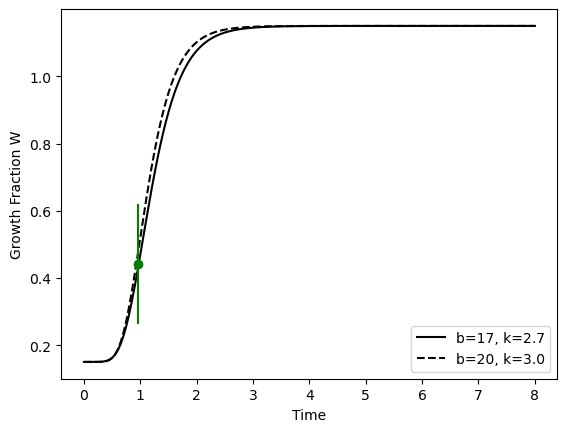

In [9]:
A = 1
b=17
k=2.7
W1 = .15+gf(A, b, k, t)
ts = 'b={}, k={}'.format(b,k)
plt.plot(t,W1,'-',c='k',label=ts)

A = 1
b=20
k=3.
W2 = .15+gf(A, b, k, t)
ts = 'b={}, k={}'.format(b,k)
plt.plot(t,W2,'--',c='k',label=ts)

plt.errorbar(dyr[0]-dy_flo, s0['mean'], yerr=s0['std'], c='green')
plt.plot(dyr[0]-dy_flo, s0['mean'],'og')

plt.ylabel('Growth Fraction W')
plt.xlabel('Time')
plt.legend()

-1.830509574779482e-05
[108] [10.8] [0.90363103]


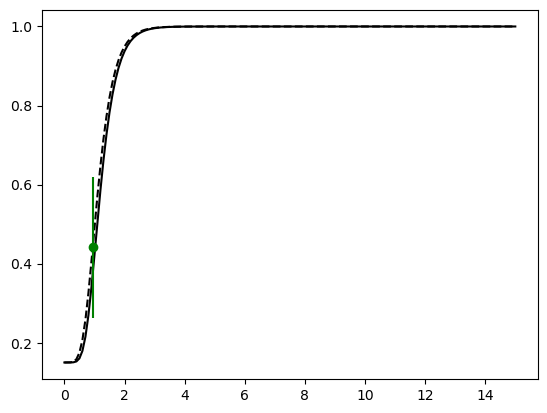

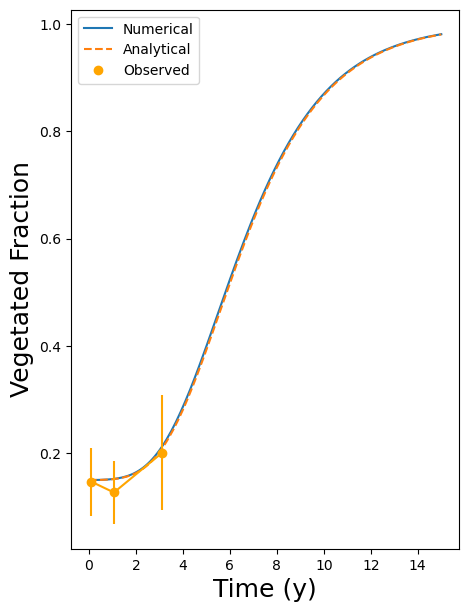

In [10]:
def gompertz(W,t,k=1,A=1):
    dWdt = k*W*(np.log(A/W))
    return dWdt

t=np.linspace(0, 15, 151)

# Recovery from overwash...match one point from post-Florence
A = .85
b=17
k=2.7
WF = .15+gf(A, b, k, t)
ts = 'b={}, k={}'.format(b,k)

WFn = .15+np.squeeze( odeint(gompertz, 1e-6, t, args=(k, A)) ) 

# A = 1
# b=20
# k=3.
# W2 = .15+gf(A, b, k, t)
# ts = 'b={}, k={}'.format(b,k)
# plt.plot(t,W2,'--',c='k',label=ts)

plt.plot(t,WF,'-',c='k',label=ts)
plt.plot(t,WFn,'--',c='k',label='Numerical')

plt.errorbar(dyr[0]-dy_flo, s0['mean'], yerr=s0['std'], c='green')
plt.plot(dyr[0]-dy_flo, s0['mean'],'og')

# Match non-veg (lack of) recovery after Dorian
k=.4
A=.85
W0 = 1e-4
Wn = .15+np.squeeze( odeint(gompertz, W0, t, args=(k, A)) ) 
b=9.25
Wa = .15+A*np.exp(-b*np.exp(-k*t))

fig = plt.figure(figsize=(7,5))
plt.plot(t,Wn,label='Numerical')
plt.plot(t,Wa,'--',label='Analytical')

print(np.max( (Wa-Wn.T) ))
i99 = np.argwhere(Wn>=.9)[0]
print(i99,t[i99],Wn[i99])

# A = .85
# b=10
# k=2.7
# W1 = .15+gf(A, b, k, t)
# ts = 'b={}, k={}'.format(b,k)
# plt.plot(t,W1,'-',c='k',label=ts)

# A = .85
# b=50
# k=1
# W2 = .15+gf(A, b, k, t)
# ts = 'b={}, k={}'.format(b,k)
# #
# plt.plot(t,W2,'--',c='k',label=ts)

tsm_dor = [s1['mean'], s2['mean'], s3['mean']]
tse_dor = [s1['std'], s2['std'], s3['std']]
plt.errorbar(dyr[1:]-dy_dor, tsm_dor, yerr=tse_dor, c='orange')
plt.plot(dyr[1:]-dy_dor, tsm_dor,'o',c='orange',label='Observed')

plt.ylabel('Vegetated Fraction', fontsize=18)
plt.xlabel('Time (y)', fontsize=18)
plt.legend()

-1.830509574779482e-05
[108] [10.8] [0.90363103]


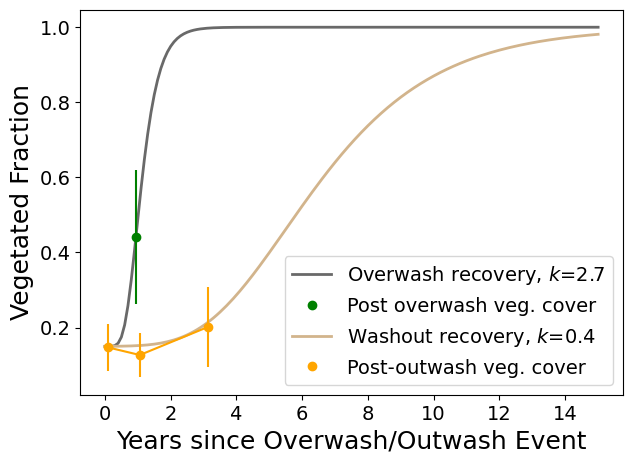

In [14]:
def gompertz(W,t,k=1,A=1):
    dWdt = k*W*(np.log(A/W))
    return dWdt

t=np.linspace(0, 15, 151)

# Recovery from overwash...match one point from post-Florence
A = .85
b=17
k=2.7
WF = .15+gf(A, b, k, t) # analytical...wont plot
ts = '$k$={}'.format(k)

WFn = .15+np.squeeze( odeint(gompertz, 1e-6, t, args=(k, A)) ) 


fig = plt.figure(figsize=(7,5))
# plt.plot(t,WF,'-',c='k',label=ts)
plt.plot(t,WFn,'-',c='dimgray',linewidth=2,label='Overwash recovery, '+ts)

plt.errorbar(dyr[0]-dy_flo, s0['mean'], yerr=s0['std'], c='green')
plt.plot(dyr[0]-dy_flo, s0['mean'],'og',label='Post overwash veg. cover')

# Match non-veg (lack of) recovery after Dorian
k=.4
A=.85
W0 = 1e-4
Wn = .15+np.squeeze( odeint(gompertz, W0, t, args=(k, A)) ) 
b=9.25
Wa = .15+A*np.exp(-b*np.exp(-k*t)) # analytical - wont plot
ts = '$k$={}'.format(k)

plt.plot(t,Wn,c='tan',linewidth=2,label='Washout recovery, '+ts)
#plt.plot(t,Wa,'--',label='Analytical')

print(np.max( (Wa-Wn.T) ))
i99 = np.argwhere(Wn>=.9)[0]
print(i99,t[i99],Wn[i99])

tsm_dor = [s1['mean'], s2['mean'], s3['mean']]
tse_dor = [s1['std'], s2['std'], s3['std']]
plt.errorbar(dyr[1:]-dy_dor, tsm_dor, yerr=tse_dor, c='orange')
plt.plot(dyr[1:]-dy_dor, tsm_dor,'o',c='orange',label='Post-outwash veg. cover')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Vegetated Fraction',fontsize=18)
plt.xlabel('Years since Overwash/Outwash Event', fontsize=18)
plt.legend(fontsize=14)
plt.savefig(ddir+'growth_curve_fits.png',dpi=200, bbox_inches='tight')